# GOSDT: Generalized Optimal Sparse Decision Trees

- The Generalized Optimal Sparse Decision Trees (GOSDT) is a decision tree learning algorithm designed to produce globally optimal and highly interpretable models. 
- Unlike conventional decision trees that use greedy heuristics, GOSDT formulates tree learning as an optimization problem, ensuring the best balance between accuracy and simplicity. 
- By incorporating regularization, GOSDT effectively prunes unnecessary branches, resulting in compact trees that enhance interpretability while maintaining strong predictive performance. 
- It is particularly useful in scenarios where model transparency, fairness, and stability are critical, such as healthcare, finance, and legal decision-making. 


## **1. Load packages**

GOSDT can be installed using `uv add gosdt` or `pip add gosdt`. 

### NOTE:
The  gosdt package  tries to import `check_X_y from sklearn.base`, but in newer versions of scikit-learn, 
`check_X_y` is located in `sklearn.utils.validation`. 
As a fix, you can edit
`.venv/lib/python3.10/site-packages/gosdt/_threshold_guessing.py`

and change it to:
```
from sklearn.base import BaseEstimator, TransformerMixin, check_X_y 
```
to 

```
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y`
```

We prefer this solution so as not the break the dependency on scikit-learn version for other examples


In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gosdt import ThresholdGuessBinarizer, GOSDTClassifier

## **2.Read the Compas recidivism dataset**




In [3]:

# Read the dataset
df = pd.read_csv("datasets/compas.csv", sep=",")
X, y = df.iloc[:, :-1], df.iloc[:, -1]
h = df.columns[:-1]

display(df.head())

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print("X train shape:{}, X test shape:{}".format(X_train.shape, X_test.shape))

,sex=female,age,juv_fel_count,juv_misd_count,juvenile_crimes,priors_count,current_charge_degree=felony,two_year_recid
0,0,69,0,0,0,0,1,0
1,0,34,0,0,0,0,1,1
2,0,24,0,0,1,4,1,1
3,0,44,0,0,0,0,0,0
4,0,41,0,0,0,14,1,1


X train shape:(5525, 7), X test shape:(1382, 7)


## **3. Set up hyperparameters for GOSDT**



In [4]:
# Parameters
GBDT_N_EST = 50
GBDT_MAX_DEPTH = 1
REGULARIZATION = 0.001
SIMILAR_SUPPORT = False
DEPTH_BUDGET = 6
TIME_LIMIT = 120
VERBOSE = True


## **4.Guess the thresholds**

**ThresholdGuessBinarizer:**	A technique that converts continuous features into binary splits based on estimated thresholds using Gradient Boosted Decision Trees (GBDTs).

Example: (e.g., "Age > 50" → 1, "Age ≤ 50" → 0).

In [5]:
# Step 1: Guess Thresholds
X_train = pd.DataFrame(X_train, columns=h)
X_test = pd.DataFrame(X_test, columns=h)
enc = ThresholdGuessBinarizer(n_estimators=GBDT_N_EST, max_depth=GBDT_MAX_DEPTH, random_state=2021)
enc.set_output(transform="pandas")
X_train_guessed = enc.fit_transform(X_train, y_train)
X_test_guessed = enc.transform(X_test)
print(f"After guessing, X train shape:{X_train_guessed.shape}, X test shape:{X_test_guessed.shape}")
print(f"train set column names == test set column names: {list(X_train_guessed.columns) == list(X_test_guessed.columns)}")

# Store feature names for later use
feature_names = X_train_guessed.columns.tolist()
print(feature_names)

After guessing, X train shape:(5525, 19), X test shape:(1382, 19)
train set column names == test set column names: True
['age <= 20.5', 'age <= 21.5', 'age <= 22.5', 'age <= 23.5', 'age <= 27.5', 'age <= 32.5', 'age <= 33.5', 'age <= 34.5', 'age <= 38.5', 'juvenile_crimes <= 0.5', 'priors_count <= 0.5', 'priors_count <= 1.5', 'priors_count <= 2.5', 'priors_count <= 3.5', 'priors_count <= 4.5', 'priors_count <= 5.5', 'priors_count <= 7.5', 'priors_count <= 9.5', 'age <= 52.5']


## **5. Guess the lower bounds**

-	A Gradient Boosting Classifier is trained on the threshold-binarized dataset (X_train_guessed).
-	Predicts labels (warm_labels) for training data, which are used as a starting point for GOSDT optimization.

In [6]:
# Step 2: Guess Lower Bounds
enc = GradientBoostingClassifier(n_estimators=GBDT_N_EST, max_depth=GBDT_MAX_DEPTH, random_state=42)
enc.fit(X_train_guessed, y_train)
warm_labels = enc.predict(X_train_guessed)

## **6. Train GOSDT classifier**

Creates a GOSDT classifier with:
-	Regularization (REGULARIZATION) → Controls tree complexity (penalizes overfitting).
-	Depth budget (DEPTH_BUDGET) → Limits tree depth to control model size.
-	Time limit (TIME_LIMIT) → Stops training after a certain period.
-	Warm labels (y_ref=warm_labels) → Uses GBDT predictions to speed up convergence.
-	Fits the GOSDT model on the threshold-binarized training data (X_train_guessed).

In [7]:
# Step 3: Train the GOSDT classifier
clf = GOSDTClassifier(regularization=REGULARIZATION, similar_support=SIMILAR_SUPPORT, time_limit=TIME_LIMIT, depth_budget=DEPTH_BUDGET, verbose=VERBOSE) 
clf.fit(X_train_guessed, y_train, y_ref=warm_labels)

Using Configuration: {
    "cancellation": true,
    "depth_budget": 7,
    "diagnostics": false,
    "feature_transform": true,
    "look_ahead": true,
    "model_limit": 1,
    "non_binary": false,
    "profile": "",
    "reference_LB": false,
    "regularization": 0.0010000000474974513,
    "rule_list": false,
    "similar_support": false,
    "time_limit": 120,
    "trace": "",
    "tree": "",
    "upperbound": 0.0,
    "verbose": true,
    "worker_limit": 1
}

[WARNING] The off-by-one in the depth_budget option here is a consequence of the C++ code treating unbounded depth trees as trees of depth 0 and single node leaf trees as trees of depth 1.

Initializing Optimization Framework.
Starting Optimization.
Time: 0, Objective: [0.32481, 0.357475], Boundary: 0.0326651, Graph Size: 1, Queue Size: 38
Time: 0.215, Objective: [0.32481, 0.357475], Boundary: 0.0326651, Graph Size: 4826, Queue Size: 19007
Time: 0.369, Objective: [0.32481, 0.357475], Boundary: 0.0326651, Graph Size: 7504, Qu

GOSDTClassifier(depth_budget=6, regularization=0.001, similar_support=False,
                time_limit=120, verbose=True)

## **7. Evaluate the model**



In [8]:
# Step 4: Evaluate the model
print("Evaluating the model, extracting tree and scores", flush=True)

print(f"Model training time: {clf.result_.time}")
print(f"Training accuracy: {clf.score(X_train_guessed, y_train)}")
print(f"Test accuracy: {clf.score(X_test_guessed, y_test)}")

Evaluating the model, extracting tree and scores
Model training time: 0.558
Training accuracy: 0.6821719457013574
Test accuracy: 0.6888567293777135


/Users/Dhaneshr/code/interpretability-bootcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/Dhaneshr/code/interpretability-bootcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## **8. Visualize the GOSDT model**

We are using the `graphviz` library to visualize the tree. Ensure graphviz executable is installed and in the path
```
# using macos, install with brew install graphviz
# using ubuntu, install with sudo apt-get install graphviz
# using windows, download and install from https://graphviz.org/download/
```

['age <= 20.5', 'age <= 21.5', 'age <= 22.5', 'age <= 23.5', 'age <= 27.5', 'age <= 32.5', 'age <= 33.5', 'age <= 34.5', 'age <= 38.5', 'juvenile_crimes <= 0.5', 'priors_count <= 0.5', 'priors_count <= 1.5', 'priors_count <= 2.5', 'priors_count <= 3.5', 'priors_count <= 4.5', 'priors_count <= 5.5', 'priors_count <= 7.5', 'priors_count <= 9.5', 'age <= 52.5']


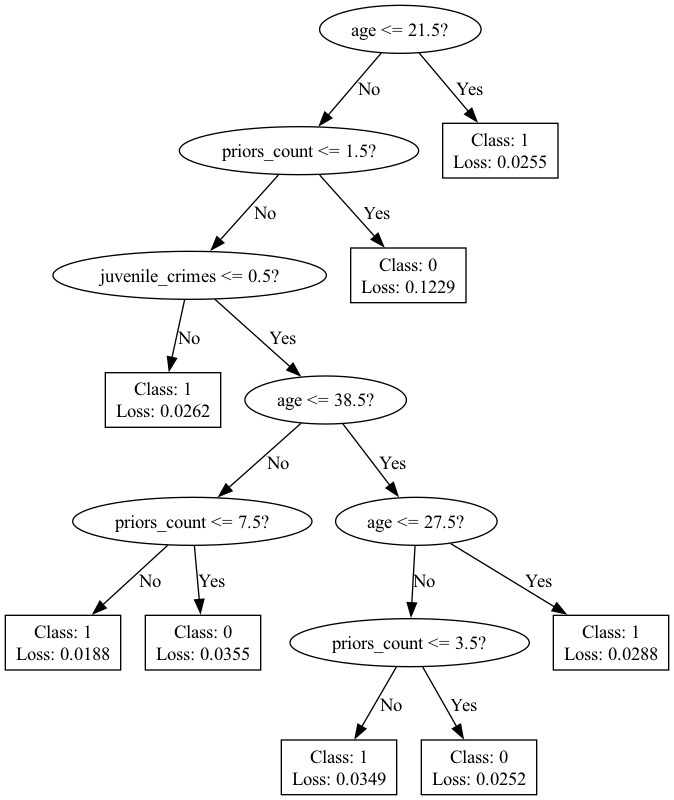

In [9]:
from graphviz import Digraph
import json
def visualize_gosdt_tree(tree, feature_names):
    """Visualize GOSDT Decision Tree using Graphviz."""
    dot = Digraph(comment="GOSDT Decision Tree")
    
    node_counter = 0  # Global counter to ensure unique node IDs

    def add_nodes_edges(node, parent=None, edge_label=""):
        """Recursive function to traverse the tree and add nodes/edges."""
        nonlocal node_counter
        node_id = node_counter
        node_counter += 1

        if "feature" in node:  # Internal node
            feature_label = f"{feature_names[node['feature']]}" if node['feature'] < len(feature_names) else f"Feature {node['feature']}"
            label = f"{feature_label}?"
            dot.node(str(node_id), label)
            
            if parent is not None:
                dot.edge(str(parent), str(node_id), label=edge_label)

            add_nodes_edges(node["false"], node_id, "No")  # Left (False) branch
            add_nodes_edges(node["true"], node_id, "Yes")  # Right (True) branch

        else:  # Leaf node
            label = f"Class: {node['prediction']}\nLoss: {node['loss']:.4f}"
            dot.node(str(node_id), label, shape="box")

            if parent is not None:
                dot.edge(str(parent), str(node_id), label=edge_label)

    # Start visualization from the root node
    add_nodes_edges(tree[0])  # Root node is the first element in the list
    return dot

# Extract feature names from dataset
feature_names = X_train_guessed.columns.tolist()  # Assuming X_train is your DataFrame
print(feature_names)

# Parse the tree JSON string into a dictionary
tree_dict = json.loads(clf.result_.model)

# Visualize the tree
dot = visualize_gosdt_tree(tree_dict, feature_names)
dot.render("gosdt_tree", format="png", view=False)  # Save and open
# Show the tree by loading the png file saved in ipython notebook
from IPython.display import Image
Image("gosdt_tree.png")


## **9. How to Read This Tree?**

- Each internal node (oval) represents a **decision rule** (e.g., `"age ≤ 21.5?"`).
- Each leaf node (rectangle) represents a **prediction**:
  - `"Class: 1"` → **High risk of recidivism** (re-offense likely).
  - `"Class: 0"` → **Low risk of recidivism** (re-offense unlikely).
- Edges labeled “Yes” or “No” show **decision paths**.
- Loss values indicate the **error at that node**.

---

## Step-by-Step Decision Process

### **1.Root Node: `age ≤ 21.5?`**
- **If “Yes”** → The person is **young**, **high risk of recidivism** (**Class: 1, Loss: 0.0255**).
- **If “No”** → Check **`priors_count`** (past convictions).

### **2️.`priors_count ≤ 1.5?`**
- **If “Yes”** → The person has **few prior offenses**, **low risk** (**Class: 0, Loss: 0.1229**).
- **If “No”** → Check **juvenile criminal history**.

### **3️.`juvenile_crimes ≤ 0.5?`**
- **If “No”** → **High risk** (**Class: 1, Loss: 0.0262**).
- **If “Yes”** → Check **age**.

### **4️.`age ≤ 38.5?`**
- **If “No”** → Check **`priors_count ≤ 7.5?`**:
  - **If “No”** → **High risk** (**Class: 1, Loss: 0.0188**).
  - **If “Yes”** → **Low risk** (**Class: 0, Loss: 0.0355**).
- **If “Yes”** → Check **`age ≤ 27.5?`**:
  - **If “Yes”** → **High risk** (**Class: 1, Loss: 0.0288**).
  - **If “No”** → Check **`priors_count ≤ 3.5?`**:
    - **If “No”** → **High risk** (**Class: 1, Loss: 0.0349**).
    - **If “Yes”** → **Low risk** (**Class: 0, Loss: 0.0252**).

**Key observations:**

1. Age is the strongest predictor:
	-	Younger individuals (≤21.5) are more likely to re-offend.
	-	Older individuals with few priors are less likely to re-offend.
2. Prior offenses (priors_count) are critical:
	-	If priors_count ≤ 1.5, recidivism is unlikely.
	-	If priors_count ≥ 7.5, recidivism is very likely.
3.	Juvenile crimes (juvenile_crimes) increase risk:
	-	If an individual has a juvenile criminal record, their risk of re-offending is higher.
4.	Aging out of crime?
	-	If age ≥ 38.5 and few priors, the risk decreases significantly.

## **10. Contrast with the CART decision tree algorithm**

CART (Classification and Regression Trees) is a widely used decision tree algorithm that constructs predictive models for classification and regression tasks. It was introduced by Breiman et al. (1984) and forms the foundation of many modern tree-based models.

While tree based decision tree are fundamentally interpretable, this becomes very challenging when the tree becomes too large. We can see this phenomemenon clearly in the following exaple were we train a conventional decision tree on the same dataset


Training accuracy: 0.6886877828054299
Test accuracy: 0.6736613603473227


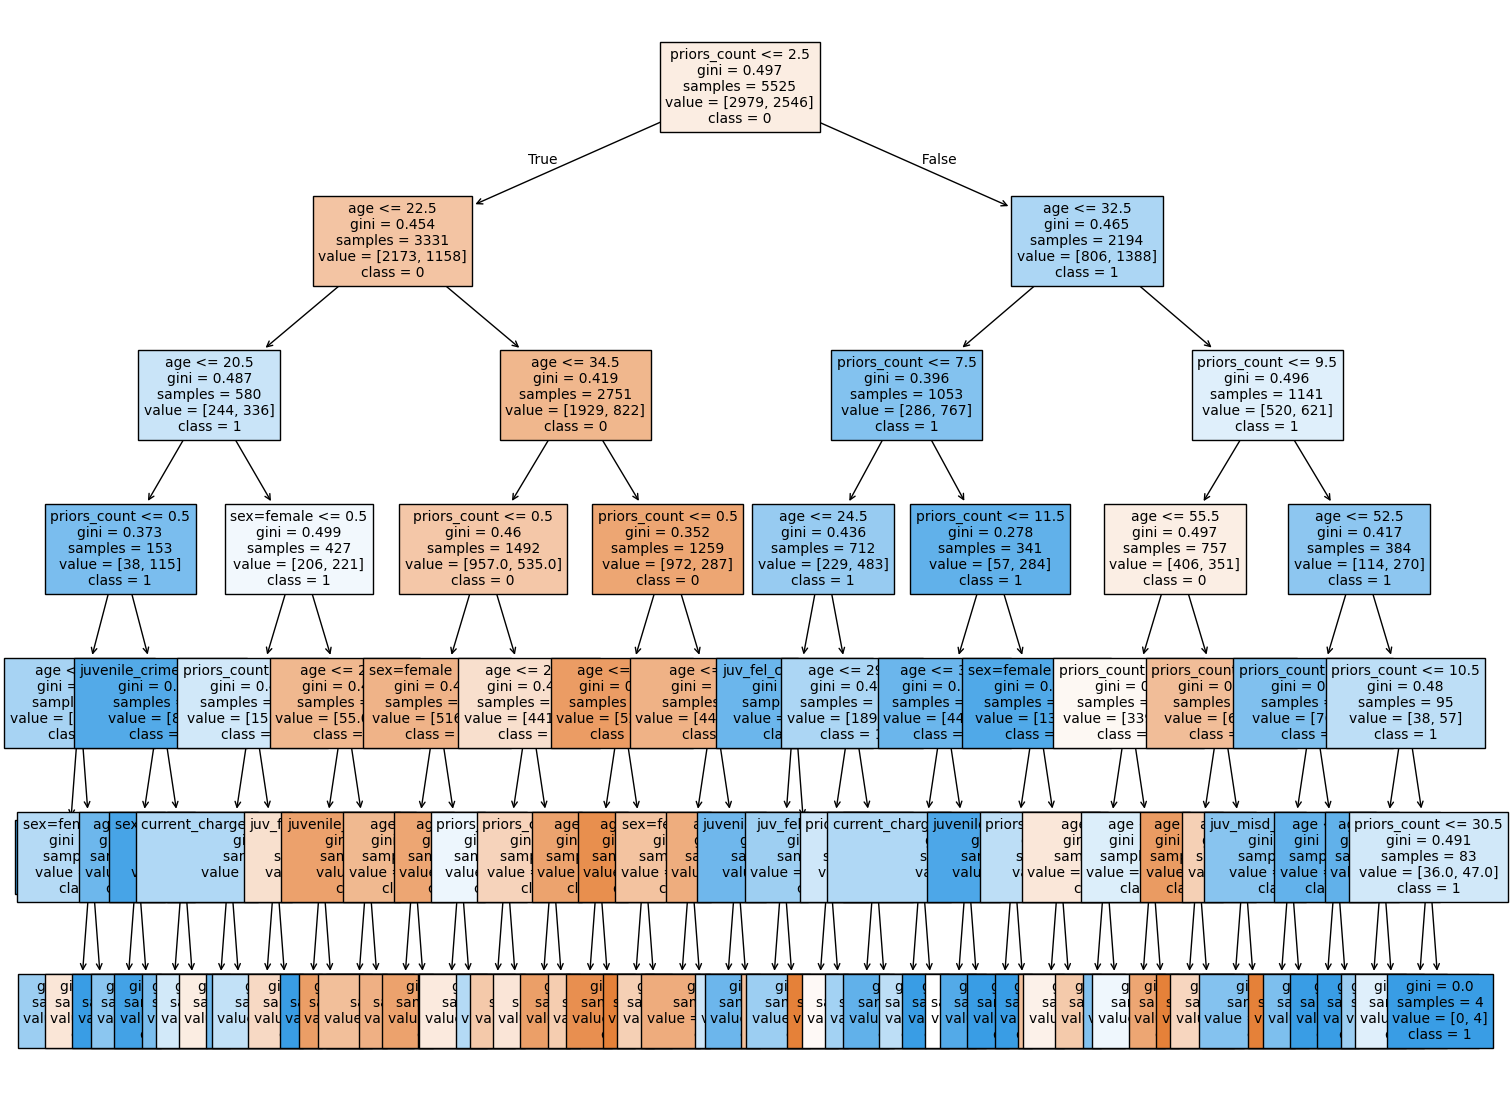

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a conventional Decision Tree
cart_clf = DecisionTreeClassifier(max_depth=6, random_state=42)  # Limit depth for interpretability
cart_clf.fit(X_train, y_train)

print(f"Training accuracy: {cart_clf.score(X_train, y_train)}")
print(f"Test accuracy: {cart_clf.score(X_test, y_test)}")

# Visualize the Conventional Decision Tree
plt.figure(figsize=(18, 14))
plot_tree(cart_clf, feature_names=X.columns, class_names=["0", "1"], filled=True, fontsize=10)
plt.show()

# 📌 GOSDT vs. Conventional Decision Trees (CART)

| **Aspect**            | **GOSDT (Generalized Optimal Sparse Decision Trees)** | **CART (Conventional Decision Tree)** |
|----------------------|--------------------------------------------------|-------------------------------------|
| **Optimization Approach** | **Global Optimization** (Considers all possible trees for best regularized fit) | **Greedy Optimization** (Splits at best feature locally, no guarantee of global optimality) |
| **Interpretability**  | **Sparse & Optimal Tree** (Minimizes complexity while preserving accuracy) | **Larger Tree, More Splits** (Prone to overfitting unless pruned) |
| **Regularization**    | **Uses explicit regularization** (`regularization=0.001`) to encourage sparsity | **Uses pruning (`max_depth`)** to prevent overfitting |
| **Training Time**     | **Longer** (Solves an optimization problem) | **Faster** (Uses greedy heuristics) |
| **Accuracy**         | **More stable, lower variance** (Regularization prevents overfitting) | **Higher variance, more prone to overfitting** |
| **Feature Selection** | **Automatic feature selection** due to global optimization | **Uses all features unless pruned** |
| **Depth of Tree**     | **Optimally limited** based on dataset complexity | **Can be very deep unless restricted** |
| **Use Case**         | When **interpretability & optimality** are critical | When **speed & good enough results** are needed |